In [201]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from time import gmtime, strftime
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
features = [
  'delivery_type', 'total_size', 'distance', 
  'delivery_dt', 'lat', 'long', 'task_around',

  'pickup_effective_dt', 'city', 'total_task', 'cost', 'company_id'
]
stad_cols = [
  'total_size', 'distance',
  'task_around', 'cost'
]
stad_cols_2 = [
  'lat', 'long',
]
stad_dates = [
  'delivery_dt', 'pickup_effective_dt'
]
#'pickup_effective_dt',
target = 'delivery_effective'
RANDOM = 1999

RESULTS = './results.csv'

In [202]:
class display(object):
  """Display HTML representation of multiple objects"""
  template = """<div style="float: left; padding: 10px;">
  <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
  </div>"""
  def __init__(self, *args):
    self.args = args

  def _repr_html_(self):
    return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.args)

  def __repr__(self):
    return '\n\n'.join(a + '\n' + repr(eval(a)) for a in self.args)

def save_params(scalers, metrics):
  metrics_values = []
  for value in metrics.values():
    metrics_values.append(str(value))
  metada = []
  for key, value in scalers.items():
    metada.append({ key: value })
  with open(RESULTS, 'a') as f:
    f.write(f'{",".join(metrics_values)},{metada}\n')

In [203]:
df = pd.read_pickle("../data/shippify_icd_task_new.pkl", compression='gzip')
#df = df[ (df['delivery_dt'].dt.month >= 6) & (df['delivery_dt'].dt.month <= 7) ]
#df = df[ df['delivery_dt'].dt.month == 6 ]
df.delivery_type = df.delivery_type.astype('category').cat.codes
df.total_size = df.total_size.astype('category').cat.codes

df.delivery_dt = df.delivery_dt.view('i8') / 1e9
df.pickup_effective_dt = df.pickup_effective_dt.view('i8') / 1e9
df.delivery_effective = df.delivery_effective.view('i8') / 1e9

"""
  z_scores = stats.zscore(df['task_around'])
  abs_z_scores = np.abs(z_scores)
  filtered_entries = abs_z_scores < 3
  df = df[ filtered_entries ]
"""
pass

In [204]:
df.network_id.value_counts()

286    205763
301     16405
215      4366
1         290
358         4
Name: network_id, dtype: int64

In [205]:
df.columns

Index(['id', 'route_id', 'creation_date', 'delivery_type', 'city', 'cost',
       'total_size', 'distance', 'company_id', 'company_type', 'network_id',
       'pickup_dt', 'pickup_effective_dt', 'pickuplat', 'pickuplng',
       'pickup_location', 'delivery_dt', 'delivery_effective', 'lat', 'long',
       'delivery_location', 'items', 'total_task', 'is_late', 'task_around',
       'class_neighboring'],
      dtype='object')

In [206]:
scaler = MinMaxScaler(feature_range=(0, 10))
df[stad_cols] = scaler.fit_transform(df[stad_cols])

scaler_2 = MinMaxScaler(feature_range=(0, 10))
df[stad_cols_2] = scaler_2.fit_transform(df[stad_cols_2])

scaler_3 = MinMaxScaler(feature_range=(0, 100))
df[stad_dates] = scaler_3.fit_transform(df[stad_dates])

""" scaler_target = MinMaxScaler(feature_range=(0, 1000))
df[target] = scaler_target.fit_transform(df[[target]]) """

' scaler_target = MinMaxScaler(feature_range=(0, 1000))\ndf[target] = scaler_target.fit_transform(df[[target]]) '

In [207]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.25, random_state=RANDOM)

model = LinearRegression()
reg = model.fit(X_train, y_train)
"""
  MAE  14291.68545723561
  MAPE  8.975251299191215e-06
  RMSE  43606.385764242266
  R2  0.9963369581756835
"""
y_pred = model.predict(X_test)

pred_bool = np.where(y_pred > X_test['delivery_dt'], True, False)
test_bool = np.where(y_test > X_test['delivery_dt'], True, False)

mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

In [208]:
THRESHOLD = 2
X_test['pred'] = y_pred * 1e9 #scaler_target.inverse_transform(np.array(y_pred).reshape(-1,1))
X_test['delivery_effective'] = y_test * 1e9#scaler_target.inverse_transform(np.array(y_test).reshape(-1,1))
X_test[stad_dates] = scaler_3.inverse_transform(X_test[stad_dates]) * 1e9
X_test.delivery_dt = X_test.delivery_dt.astype('datetime64[ns]')
X_test.delivery_effective = X_test.delivery_effective.astype('datetime64[ns]')
X_test.pred = X_test.pred.astype('datetime64[ns]')
X_test['delta'] = (X_test['delivery_effective'] - X_test['pred']).dt.total_seconds().apply(abs) / 3600

delta_pred_bool = np.where(((X_test['pred'] - X_test['delivery_dt']).dt.total_seconds()/3600) > THRESHOLD, True, False)
delta_test_bool = np.where(((X_test['delivery_effective'] - X_test['delivery_dt']).dt.total_seconds()/3600) > THRESHOLD, True, False)

f1_delta = f1_score(delta_pred_bool, delta_test_bool)

save_params({
  'features'    : features,
  'stad_cols'   : scaler.get_params(deep=True),
  'stad_cols_2' : scaler_2.get_params(deep=True),
  'stad_dates'  : scaler_3.get_params(deep=True),
},{
  'MAE' : mae,
  'MAPE': mape,
  'RMSE': rmse,
  'R2'  : r2,
  'f1'  : f1_delta
})
print('{0:10s}: {1}\n{2:10s}: {3}\n{4:10s}: {5}\n{6:10s}: {7}\n{8:10s}: {9}'.format('MAE', mae, 'MAPE', mape, 'RMSE', rmse, 'r2', r2, 'f1 (delta)', f1_delta))

MAE       : 14628.425300028874
MAPE      : 9.171469062035806e-06
RMSE      : 62331.5954855669
r2        : 0.9992661667693703
f1 (delta): 0.782480828523994


In [209]:
#print(X_test[ X_test['delta'] > 20 ].describe())
X_test[ X_test['delta'] > 24 ]

,delivery_type,total_size,distance,delivery_dt,lat,long,task_around,pickup_effective_dt,city,total_task,cost,company_id,network_id,pred,delivery_effective,delta
103689,1,10.0,0.078276,2020-07-22 20:20:45,8.627886,0.266205,2.776058,1.595429e+18,3,226828,0.386286,4418,301,2020-07-22 19:16:09.374874112,2020-07-28 19:36:52,144.345174
13094,1,2.5,0.093397,2020-06-12 14:30:00,8.856669,0.308385,1.517028,1.591971e+18,3,226828,0.428571,982,286,2020-06-12 19:33:48.778904320,2020-06-14 14:29:18,42.924784
247720,1,2.5,0.064340,2020-08-22 13:00:34,8.514768,0.254371,1.279670,1.598116e+18,3,226828,0.428571,982,286,2020-08-22 22:37:51.286067456,2020-08-24 03:28:53,28.850476
219798,1,2.5,0.115338,2020-07-30 16:00:00,7.485217,0.246485,0.712074,1.596139e+18,3,226828,0.571429,4656,286,2020-07-31 05:33:47.885306368,2020-08-04 23:21:14,113.790587
169664,1,2.5,0.071753,2020-07-20 16:00:00,8.613102,0.257755,4.716202,1.595260e+18,3,226828,0.571429,4656,286,2020-07-20 23:22:35.268107776,2020-07-22 20:04:05,44.691592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64297,1,2.5,0.075904,2020-08-18 14:00:00,8.554632,0.261943,2.889577,1.597763e+18,3,226828,0.428571,982,286,2020-08-18 20:38:54.730136320,2020-08-20 12:38:19,39.990075
242146,1,2.5,0.040620,2020-06-11 14:00:23,7.680585,0.233526,0.722394,1.591891e+18,3,226828,0.000000,3747,286,2020-06-11 23:15:09.784577792,2020-06-13 01:30:59,26.263671
247834,1,2.5,0.051591,2020-06-15 18:30:00,8.341244,0.239962,6.295150,1.592261e+18,3,226828,0.428571,982,286,2020-06-16 03:57:05.861063680,2020-06-17 17:11:08,37.233927
197002,1,2.5,0.079758,2020-08-01 18:00:00,8.551395,0.274822,1.919505,1.596302e+18,3,226828,0.428571,982,286,2020-08-01 22:40:12.481283328,2020-08-02 23:19:46,24.659311


In [210]:
X_test[ X_test['delta'] < 24 ]

,delivery_type,total_size,distance,delivery_dt,lat,long,task_around,pickup_effective_dt,city,total_task,cost,company_id,network_id,pred,delivery_effective,delta
42968,1,2.5,0.057521,2020-08-15 14:00:00,8.165807,0.239238,2.218782,1.597501e+18,3,226828,0.428571,3747,286,2020-08-15 21:31:53.249838336,2020-08-15 16:20:48,5.184792
122331,1,2.5,0.017493,2020-08-11 21:15:03,8.368236,0.210821,3.209494,1.597181e+18,3,226828,0.592000,1874,286,2020-08-12 02:31:24.370432768,2020-08-11 22:04:29,4.448714
138225,1,10.0,0.037952,2020-06-10 19:43:02,8.341906,0.169611,0.897833,1.591804e+18,3,226828,0.386286,4418,301,2020-06-10 20:23:38.804427776,2020-06-10 18:15:42,2.132446
87058,1,10.0,0.057817,2020-06-10 23:24:35,8.247421,0.215654,1.300310,1.591808e+18,3,226828,0.386286,4418,301,2020-06-10 21:28:28.297778176,2020-06-10 20:22:51,1.093694
91659,1,2.5,0.048922,2020-08-11 14:31:10,7.975562,0.238998,0.670795,1.597155e+18,3,226828,0.428571,3747,286,2020-08-11 21:23:58.034134528,2020-08-11 22:45:36,1.360546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71906,1,10.0,0.019865,2020-07-07 17:00:04,8.429306,0.238679,5.108359,1.594142e+18,3,226828,0.637714,4185,286,2020-07-07 20:08:40.153672704,2020-07-07 18:29:36,1.651154
6039,1,2.5,0.065823,2020-07-09 16:00:00,8.489713,0.237469,3.457172,1.594310e+18,3,226828,0.571429,3469,286,2020-07-09 22:53:16.844733952,2020-07-09 18:41:27,4.197179
172523,1,10.0,0.027574,2020-07-07 13:00:14,7.931875,0.085490,0.712074,1.594131e+18,3,226828,0.719931,1092,286,2020-07-07 16:33:23.625411584,2020-07-07 16:02:29,0.515174
180957,1,2.5,0.061079,2020-08-14 14:00:00,8.499985,0.248174,4.179567,1.597414e+18,3,226828,0.428571,982,286,2020-08-14 19:27:47.167463424,2020-08-14 18:28:18,0.991435


<AxesSubplot:xlabel='delta', ylabel='Density'>

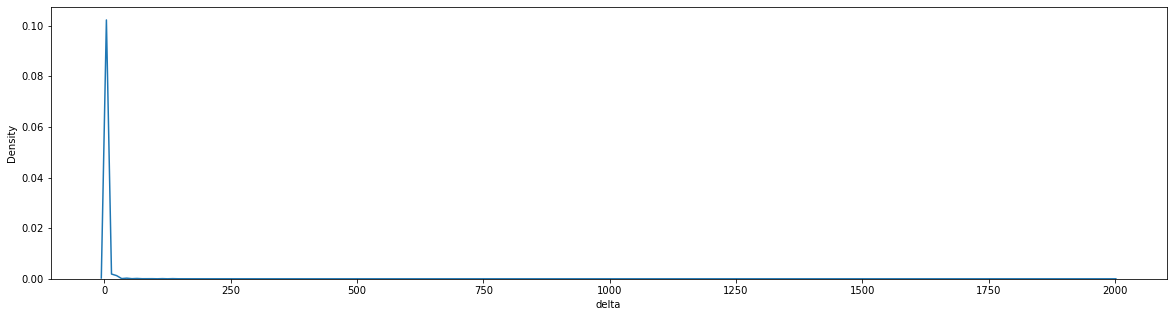

In [211]:
%matplotlib inline
plt.figure(figsize=(20,5))
sns.kdeplot(data=X_test['delta'])